In [1]:
%matplotlib inline
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Non-linear resonator dynamics simulation

The purpose of this notebook is to simulate ${\lambda}/{4}$ coplanar waveguide resonators, capacitively coupled to an open transmission line in a notch configuration.

<br>

<div>
<img src="attachment:TLS-Schematics.png" width="300"/>
</div>

These resonators are designed and assumed to behave linearly, described as a harmonic LC oscillator to a generally satisfactory degree. 
We explore whether defects and loss channels, such as parasitic TLS, can give rise to non-linearities that are overlooked in ideal models.

<br>

<div>
<img src="attachment:Setup-drawing.png" width="500"/>
</div>

<br>
Our goal is to simulate the internal dynamics of the resonator $(a)$.
Nevertheless, we only have direct access to information at the input $(a_{in})$ and output $(a_{in})$ of the system.
Therefore, to calculate the intra-cavity field we use input-output theory to obtain

$$ \dfrac{1}{\sqrt{G}} a_{out} = \dfrac{1}{\sqrt{\mathcal{A}}} a_{in} + \lambda a \quad \rightarrow \quad a = \dfrac{1}{\lambda} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right), $$

where $G$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, and $\lambda$ represents the waveguide-resonator coupling rate.

The dynamics of the resonator are described by the Heisenberg equation of motion 

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \kappa_{TLS}(a) a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}, $$

where $\omega_r$ indicates the resonant frequency, $\kappa_0$ the linear dissipation and $\kappa_{TLS}(a)$ the non-linear dissipation due to the TLS of the cavity.

The TLS non-linear dissipation is given by

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}}  $$

Including this expression in the equation of motion we get

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}} a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}. $$

We now rewrite this expression in terms of the output and input fields as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_0 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left[ \left( \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right| \right)/(|\lambda| a_c) \right]^2}} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

We also consider two known drive tones of the form

$$ a_{in} = F_0 \left( \cos({\omega_1}t) + \cos({\omega_2}t) \right) $$

We then solve the differential equation numerically using the following parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from ipywidgets import interactive
from tqdm import tqdm
from scipy.optimize import curve_fit

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [3]:
# Functions
def eom_nonlinear(time, state, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, alpha=0, beta=0):
    # resonant frequency
    ωr = 2*π * fr
    
    # Phase difference
    phase_diff = np.exp(1.0j*(alpha-beta))
    
    # state normalized by gain
    state_norm = state / np.sqrt(gain)
    
    # drives and its derivatives normalized by attenuation
    drives_norm = phase_diff * drives(time) / np.sqrt(att)
    ddrives_norm = phase_diff * ddrives(time) / np.sqrt(att)
    
    return  np.sqrt(gain) * (-1.0j*ωr*(state_norm-drives_norm) - kappa0*(state_norm-drives_norm) - kappa_tls/np.sqrt(1+((np.abs(state_norm-drives_norm)/(ac*lambd))**2))*(state_norm-drives_norm) + ddrives_norm + lambd**2*drives_norm)


def eom_nonlinear_real(time, state_real, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, alpha=0, beta=0):
    state_complex = state_real[::2] + 1j*state_real[1::2]
    ret_complex = eom_nonlinear(time, state_complex, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, alpha, beta)
    tmp = np.zeros(len(ret_complex)*2)
    tmp[::2] = np.real(ret_complex)
    tmp[1::2] = np.imag(ret_complex)
    
    return tmp


def imp_drive(time, fd1, fd2, B, φ1=0, φ2=0):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return B*(np.cos(ω1*time + φ1) + np.cos(ω2*time + φ2))


def imp_drive_derivative(time, fd1, fd2, B, φ1=0, φ2=0):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return -B*(ω1*np.sin(ω1*time + φ1) + ω2*np.sin(ω2*time + φ2))


def nonlinear_simulation(fr, kappa0, kappa_tls, ac, lambd, fd1, fd2, B, alpha=0, beta=0):
    # Drive tones
    drives = partial(imp_drive, fd1=fd1, fd2=fd2, B=B)
    ddrives = partial(imp_drive_derivative, fd1=fd1, fd2=fd2, B=B)
    
    # Integrator
    o = ode(eom_nonlinear_real).set_integrator('lsoda', atol=1e-11, rtol=1e-11)
    o.set_f_params(fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, alpha, beta)
    o.set_initial_value(y0, 0)
    
    # Time-domain solution
    y_all = np.zeros((len(t_all), len(y0)))
    for i,t in enumerate(t_all):
        o.integrate(t)
        y_all[i] = o.y
        
    # Merge the results onto the complex plane
    field_all = y_all[:,0] + 1.0j*y_all[:,1]
    
    # We save one oscillation once we reached the steady state
    field = field_all[-N-1:-1]
    t = t_all[-N-1:-1]
    
    # Fourier domain solution
    Field = np.fft.fft(field) / len(field)
    freqs = np.fft.fftfreq(len(t), d=dt)
        
    # Drive indices
    ind_drives = np.array([954, 956, 19044, 19046])
    
    # Imps indices
    nimps = 40
    ind_imp_p = np.arange(954-nimps, 956+nimps+2, 2)
    ind_imp_n = np.arange(19044-nimps, 19046+nimps+2, 2)
    ind_imp = np.append(ind_imp_p, ind_imp_n)
       
    # Generated drive array in the frequency and time domain
    Field_in = np.zeros_like(Field, dtype=complex)
    Field_in[ind_drives] = 0.5
    field_in = np.fft.ifft(Field_in)
    field_in *= len(field_in)
    
    return Field, Field_in, field_all, field, field_in, freqs, t, drives, ind_imp


def recon_nonlinear(Field, Field_in, field, field_in, freqs, indices, order):
    # Angular frequency
    ω = 2*π * freqs
    
    # Create H-matrix
    col1 = (1.0j*ω*(Field/np.sqrt(gain) - Field_in/np.sqrt(att)))[indices]
    col2 = 1.0j*(Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    col3 = (Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    
    # Merge columns
    H = np.vstack((col1, col2, col3))
    
    # Non-linear damping terms
    for exp_ind, exp_val in enumerate(order):
        col = np.fft.fft(np.abs((field/np.sqrt(gain) - field_in/np.sqrt(att))) ** exp_val * (field / np.sqrt(gain) - field_in / np.sqrt(att)))[indices] / len(field)
        H = np.vstack((H, col))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Field_in/np.sqrt(att))[indices]
    Qsin = np.imag(Field_in/np.sqrt(att))[indices]
    Qmat = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Qmat, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    lambda_recon = 1 / param_recon[0]
    fr_recon = lambda_recon * param_recon[1] / (2*π)
    kappa_arr = lambda_recon * param_recon[2:]
    
    return lambda_recon, fr_recon, kappa_arr, Q_fit


def plot_spectra(t_all_, y_all, t, y, yin, f_, Y, Yin, ylim_, ind_arr):
    figure, axis = plt.subplots(3, 1, figsize=[9, 6])
    axis[0].plot(t_all_, np.abs(y_all) )
    axis[1].plot(t, np.abs(y), label='output field')
    axis[1].plot(t, np.abs(y/np.sqrt(gain)-yin/np.sqrt(att)), label='intra-cavity field')
    axis[2].semilogy(f_, np.abs(Y), label='output field')
    axis[2].semilogy(f_, np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att)), label='intra-cavity field')
    axis[2].semilogy(f_[ind_arr], np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att))[ind_arr], '.', label='reconstructed')
    axis[0].set_ylabel('$|a|$ [a.u.]')
    axis[1].set_xlabel('time [s]')
    axis[1].set_ylabel('$|a|$ [a.u.]')
    axis[2].set_xlabel('frequency [Hz]')
    axis[2].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    axis[2].set_ylim(*ylim_)
    axis[2].legend()
    return figure


def plot_brokenaxis(x, y, ynorm, xlim1, xlim2, ylim_):
    figure, axis = plt.subplots(1, 2, sharey=True, constrained_layout=False)

    axis[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    figure.suptitle('frequency [Hz]', y=0, fontsize='medium')

    # Plot same data on both axis
    axis[0].semilogy(x, np.abs(y), label='output field')
    axis[1].semilogy(x, np.abs(y), label='output field')
    axis[0].semilogy(x, np.abs(ynorm), label='intra-cavity field')
    axis[1].semilogy(x, np.abs(ynorm), label='intra-cavity field')
    axis[0].semilogy(x[imp_ind], np.abs(ynorm[imp_ind]), '.', label='reconstruction')
    axis[1].semilogy(x[imp_ind], np.abs(ynorm[imp_ind]), '.', label='reconstruction')

    # limit each x-axis to the chosen range
    axis[0].set_xlim(*xlim1)
    axis[1].set_xlim(*xlim2)
    axis[0].set_ylim(*ylim_)

    # hide spines between both axes
    axis[0].spines['right'].set_visible(False)
    axis[1].spines['left'].set_visible(False)
    axis[1].yaxis.tick_right()
    
    # how big to make the diagonal lines in axes coordinates
    d = .015
    
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
    axis[0].plot((1-d,1+d), (-d,+d), **kwargs)
    axis[0].plot((1-d,1+d), (1-d,1+d), **kwargs)

    kwargs.update(transform=axis[1].transAxes)  # switch to the bottom axes
    axis[1].plot((-d,+d), (1-d,1+d), **kwargs)
    axis[1].plot((-d,+d), (-d,+d), **kwargs)

    # vary the distance between plots 
    figure.subplots_adjust(wspace=0.2)
    
    plt.show()


# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
def plot_paramdependence(param_arr, y, axis):
    axis.loglog(param_arr, np.abs(y[:, 954]), '.', label='drive 1')
    axis.loglog(param_arr, np.abs(y[:, 956]), '.', label='drive 2')
    axis.loglog(param_arr, np.abs(y[:, 956+2]), '.', label='3rd order' )
    axis.loglog(param_arr, np.abs(y[:, 956+4]), '.', label='5th order' )
    axis.loglog(param_arr, np.abs(y[:, 956+6]), '.', label='7th order' )
    axis.loglog(param_arr, np.abs(y[:, -1]), '.', label='background' )
    axis.legend()

In [4]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1 = 0.954
f2 = 0.956
df = 0.001
fs = 20
N = int(round(fs/df))

# Integration parameters
T = 1. / df
T_relax = 3 * T
dt = 1. / fs
t_all = dt*(np.arange((T+T_relax)/dt) + 1) 

# Initial conditions
y0 = [0,0]

In [5]:
# System parameters
f0 = 0.955
κ0 = 0.025
κtls = κ0/100
ac = 0.5
Q_factor = 1/(2*κ0)

print('SIMULATION PARAMETERS')
print(f'f0 = {f0:.3f} Hz')
print(f'κ0 = {κ0:.5f}')
print(f'κtls = {κtls:.5f}')
print(f'ac = {ac:.1f}')
print(f'λ = {λ:.0f}')
print(f'Q_factor = {Q_factor:.0f}')


# Simulation
A, Ain, a_all, a, ain, f, t_arr, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls, ac, λ, f1, f2, F0)

SIMULATION PARAMETERS
f0 = 0.955 Hz
κ0 = 0.02500
κtls = 0.00025
ac = 0.5
λ = 1
Q_factor = 20


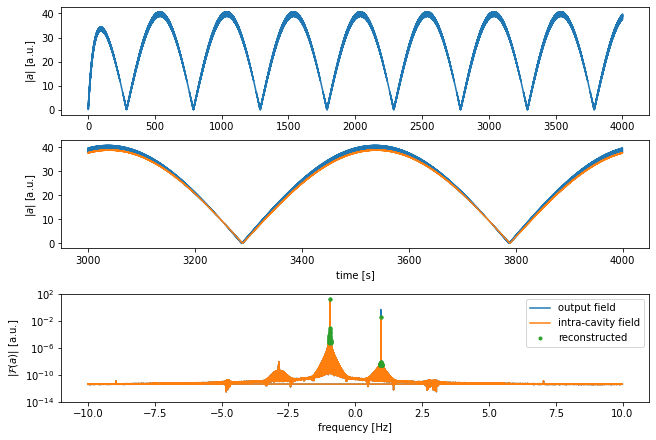

In [6]:
# Check that the generated drive matches with the simulated drive
verbose = False

if verbose:
    # Drive array in time domain
    ain_all_simu = drive(t_all)
    ain_simu = ain_all_simu[-N-1:-1]
    Ain_simu = np.fft.fft(ain_simu) / len(ain_simu)
    
    # Drives in time and frequency domain
    fig, ax = plt.subplots(3, 1, figsize=[9, 6])
    ax[0].plot(t_all, np.abs(ain_all_simu))
    ax[1].plot(t_arr, np.abs(ain_simu), label='Simulated')
    ax[1].plot(t_arr, np.abs(ain), label='Generated')
    ax[2].semilogy(f, np.abs(Ain_simu), label='Simulated')
    ax[2].semilogy(f, np.abs(Ain), label='Generated')
    ax[0].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[2].set_xlabel('frequency [Hz]')
    ax[2].set_ylabel('$|\mathcal{F}(a_{in})|$ [a.u.]')
    ax[0].set_ylim(-0.1, 3)
    ax[2].set_ylim(1e-17, 100)
    ax[2].legend()

ylim = np.array([1e-14, 100])

fig1 = plot_spectra(t_all, a_all, t_arr, a, ain, f, A, Ain, ylim, imp_ind)
plt.show()

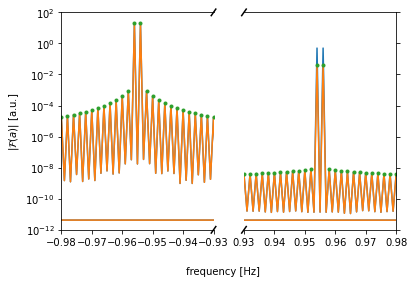

In [7]:
# Plot only the region of interest   
xlim_n = np.array([-0.98, -0.93])
xlim_p = np.array([0.93, 0.98])
ylim = np.array([1e-12, 1e2])
plot_brokenaxis(f, A, A/np.sqrt(gain)-Ain/np.sqrt(att), xlim_n, xlim_p, ylim)

### Phase plane portrait

Maybe plotting the phase plane of the non-linear system can help to understand its behaviour depending on the system parameters.
However, I am not familiar calculating phase planes in the complex amplitude formalism. 
For this reason I consider this system

$$ \ddot{x} + \alpha \dot{x} + \dfrac{\beta}{\sqrt{1+\left( \frac{|x|}{x_c} \right)^2}} + \gamma x = \delta \left[ cos(\omega_1 t) + cos(\omega_2 t) \right] $$

We rewrite it as

$$ \dfrac{dx}{dt} = \dot{x} $$
$$ \dfrac{d\dot{x}}{dt} = -\alpha \dot{x} - \dfrac{\beta}{\sqrt{1+\left( \frac{|x|}{x_c} \right)^2}}\dot{x} - \gamma x + \delta \left[ cos(\omega_1 t) + cos(\omega_2 t) \right] $$

We then plot the phase portrait at different parameter values.

In [8]:
def system(t, x, α, β, γ, δ, xc, ω1, ω2):
    return [x[1], -α*x[1] - β*x[1]/np.sqrt(1+(np.abs(x[0])/xc)**2) - γ*x[0] + δ*(np.cos(ω1*t) + np.cos(ω2*t)) ]

def parameters(α, β, γ, δ, xc, ω1, ω2):
    x = np.arange(-7, 7, 0.1)
    y = np.arange(-7, 7, 0.1)
    x, y = np.meshgrid(x, y)
    V = system(0, [x, y], α, β, γ, δ, xc, ω1, ω2)
    u, v = V

    fig2, ax2 = plt.subplots(1)
    ax2.set_xlabel('x')
    ax2.set_ylabel('$\dot{x}$')

    plt.streamplot(x, y, u, v)
    plt.show()


interactive_plot = interactive(parameters, 
                               α=(-2.0, 2.0, 0.05),
                               β=(-2, 2, 0.05),
                               γ=(-2, 2, 0.05),
                               δ=(-2, 2, 0.05),
                               xc=(0.1, 2, 0.05),
                               ω1=(0, 2, 0.05),
                               ω2=(0, 2, 0.05),
                              )
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='α', max=2.0, min=-2.0, step=0.05), FloatSlider(value…

## Parameters dependence

We start by sweeping the linear damping coefficient $\kappa_0$ while keeping $\kappa_{tls}$ and $a_c$ constant.


In [9]:
# κ0 sweep values
κ0_arr = np.logspace(-2, 1, 51)

# Spectra arrays
A_κ0 = np.zeros((len(κ0_arr), N), dtype=np.complex)
Ain_κ0 = np.zeros_like(A_κ0)
a_all_κ0 = np.zeros((len(κ0_arr), len(t_all)), dtype=np.complex)
a_κ0 = np.zeros_like(A_κ0)
ain_κ0 = np.zeros_like(A_κ0)

# κ0 sweep
with tqdm(total=len(κ0_arr), ncols=80) as pbar:

    for κ0_ind, κ0_val in enumerate(κ0_arr):
        # Simulation section
        A_κ0[κ0_ind], Ain_κ0[κ0_ind], a_all_κ0[κ0_ind], a_κ0[κ0_ind], ain_κ0[κ0_ind], f, t, drive, imp_ind = nonlinear_simulation(f0, κ0_val, κtls, ac, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [29:06<00:00, 34.24s/it]


In [10]:
def κ0_sweep(κ0_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-15, 1e3])
    figure = plot_spectra(t_all, a_all_κ0[κ0_ind_], t_arr, a_κ0[κ0_ind_], ain_κ0[κ0_ind_], f, A_κ0[κ0_ind_], Ain_κ0[κ0_ind_], ylim, imp_ind)
    figure.suptitle(f'$\kappa_0$ = {κ0_arr[κ0_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(κ0_sweep,
                 κ0_ind_=widgets.IntSlider(min=0,
                                           max=len(κ0_arr)-1,
                                           step=1,
                                           description='κ0_ind',
                                           )
                )

interactive(children=(IntSlider(value=0, description='κ0_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.κ0_sweep(κ0_ind_)>

In [11]:
def κ0_sweep_zoom(κ0_ind_):
    # IMPs plot
    xlim_n = np.array([-0.98, -0.93])
    xlim_p = np.array([0.93, 0.98])
    ylim = np.array([1e-15, 1e2])
    plot_brokenaxis(f, A_κ0[κ0_ind_], A_κ0[κ0_ind_]/np.sqrt(gain)-Ain_κ0[κ0_ind_]/np.sqrt(att), xlim_n, xlim_p, ylim)
    
# Interactive layout  
widgets.interact(κ0_sweep_zoom,
                 κ0_ind_=widgets.IntSlider(min=0,
                                           max=len(κ0_arr)-1,
                                           step=1,
                                           description='κ0_ind',
                                           )
                )

interactive(children=(IntSlider(value=0, description='κ0_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.κ0_sweep_zoom(κ0_ind_)>

Text(0, 0.5, '$|\\mathcal{F}(a)|$ [a.u.]')

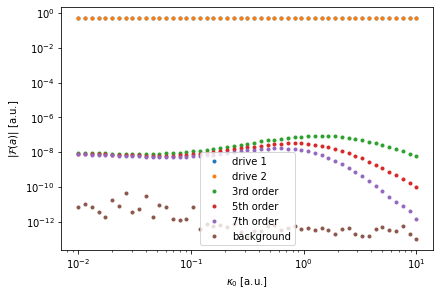

In [12]:
fig3, ax3 = plt.subplots(1)
plot_paramdependence(κ0_arr, A_κ0, ax3)
ax3.set_xlabel('$\kappa_{0}$ [a.u.]')
ax3.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')

We then sweep the TLS non-linear damping parameter, while fixing $\kappa_0$ and $a_c$.

In [13]:
# κtls sweep values
κtls_arr = np.logspace(-4, 1, 51)

# Spectra arrays
A_κtls = np.zeros((len(κtls_arr), N), dtype=np.complex)
Ain_κtls = np.zeros_like(A_κtls)
a_all_κtls = np.zeros((len(κtls_arr), len(t_all)), dtype=np.complex)
a_κtls = np.zeros_like(A_κtls)
ain_κtls = np.zeros_like(A_κtls)

# κtls sweep
with tqdm(total=len(κtls_arr), ncols=80) as pbar:

    for κtls_ind, κtls_val in enumerate(κtls_arr):
        # Simulation section
        A_κtls[κtls_ind], Ain_κtls[κtls_ind], a_all_κtls[κtls_ind], a_κtls[κtls_ind], ain_κtls[κtls_ind], f, t, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls_val, ac, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [43:14<00:00, 50.87s/it]


In [14]:
def κtls_sweep(κtls_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-15, 1e3])
    figure = plot_spectra(t_all, a_all_κtls[κtls_ind_], t_arr, a_κtls[κtls_ind_], ain_κtls[κtls_ind_], f, A_κtls[κtls_ind_], Ain_κtls[κtls_ind_], ylim, imp_ind)
    figure.suptitle(f'$\kappa tls$ = {κtls_arr[κtls_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(κtls_sweep,
                 κtls_ind_=widgets.IntSlider(min=0,
                                             max=len(κtls_arr)-1,
                                             step=1,
                                             description='κtls_ind',
                                             )
                )

interactive(children=(IntSlider(value=0, description='κtls_ind', max=50), Output()), _dom_classes=('widget-int…

<function __main__.κtls_sweep(κtls_ind_)>

In [15]:
def κtls_sweep_zoom(κtls_ind_):
    # IMPs plot
    xlim_n = np.array([-0.98, -0.93])
    xlim_p = np.array([0.93, 0.98])
    ylim = np.array([1e-14, 1e2])
    plot_brokenaxis(f, A_κtls[κtls_ind_], A_κtls[κtls_ind_]/np.sqrt(gain)-Ain_κtls[κtls_ind_]/np.sqrt(att), xlim_n, xlim_p, ylim)
    
# Interactive layout  
widgets.interact(κtls_sweep_zoom,
                 κtls_ind_=widgets.IntSlider(min=0,
                                             max=len(κtls_arr)-1,
                                             step=1,
                                             description='κtls_ind',
                                             )
                )

interactive(children=(IntSlider(value=0, description='κtls_ind', max=50), Output()), _dom_classes=('widget-int…

<function __main__.κtls_sweep_zoom(κtls_ind_)>

Text(0, 0.5, '$|\\mathcal{F}(a)|$ [a.u.]')

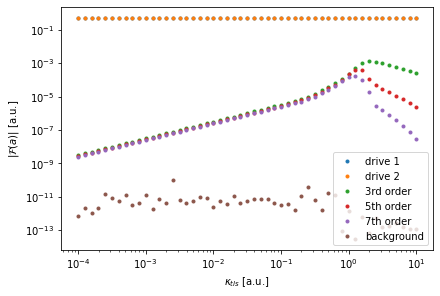

In [16]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig4, ax4 = plt.subplots(1)
plot_paramdependence(κtls_arr, A_κtls, ax4)
ax4.set_xlabel('$\kappa_{tls}$ [a.u.]')
ax4.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')

Eventually we sweep the $a_c$ parameter.

In [17]:
# ac sweep values
ac_arr = np.logspace(-4, 2, 51)

# Spectra arrays
A_ac = np.zeros((len(ac_arr), N), dtype=np.complex)
Ain_ac = np.zeros_like(A_ac)
a_all_ac = np.zeros((len(ac_arr), len(t_all)), dtype=np.complex)
a_ac = np.zeros_like(A_ac)
ain_ac = np.zeros_like(A_ac)

# ac sweep
with tqdm(total=len(ac_arr), ncols=80) as pbar:

    for ac_ind, ac_val in enumerate(ac_arr):
        # Simulation section
        A_ac[ac_ind], Ain_ac[ac_ind], a_all_ac[ac_ind], a_ac[ac_ind], ain_ac[ac_ind], f, t, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls, ac_val, λ, f1, f2, F0)
        
        pbar.update(1)

100%|███████████████████████████████████████████| 51/51 [48:15<00:00, 56.77s/it]


In [18]:
def ac_sweep(ac_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-15, 1e3])
    figure = plot_spectra(t_all, a_all_ac[ac_ind_], t, a_ac[ac_ind_], ain_ac[ac_ind_], f, A_ac[ac_ind_], Ain_ac[ac_ind_], ylim, imp_ind)
    figure.suptitle(f'$a_c$ = {ac_arr[ac_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(ac_sweep,
                 ac_ind_=widgets.IntSlider(min=0,
                                           max=len(ac_arr)-1,
                                           step=1,
                                           description='ac_ind',
                                           )
                )

interactive(children=(IntSlider(value=0, description='ac_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.ac_sweep(ac_ind_)>

In [19]:
def ac_sweep_zoom(ac_ind_):
    # IMPs plot
    xlim_n = np.array([-0.98, -0.93])
    xlim_p = np.array([0.93, 0.98])
    ylim = np.array([1e-15, 1e3])
    plot_brokenaxis(f, A_ac[ac_ind_], A_ac[ac_ind_]/np.sqrt(gain)-Ain_ac[ac_ind_]/np.sqrt(att), xlim_n, xlim_p, ylim)
    
# Interactive layout  
widgets.interact(ac_sweep_zoom,
                 ac_ind_=widgets.IntSlider(min=0,
                                           max=len(ac_arr)-1,
                                           step=1,
                                           description='ac_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='ac_ind', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.ac_sweep_zoom(ac_ind_)>

Text(0, 0.5, '$|\\mathcal{F}(a)|$ [a.u.]')

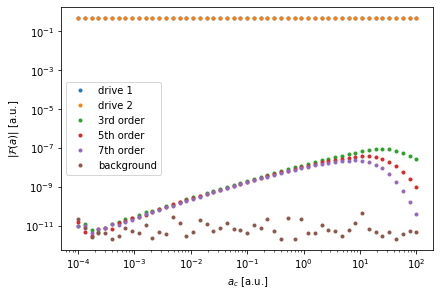

In [20]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig5, ax5 = plt.subplots(1)
plot_paramdependence(ac_arr, A_ac, ax5)
ax5.set_xlabel('$a_c$ [a.u.]')
ax5.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')

## Power dependence

We analyze the power dependence of the IMPs as a function of the drive power.
For that we sweep the parameter $F_0$.


In [21]:
# Power Sweep
F0_arr = np.logspace(-2, 2, 101)

# Spectra arrays
A_F0 = np.zeros((len(F0_arr), N), dtype=np.complex)
Ain_F0 = np.zeros_like(A_F0)
a_all_F0 = np.zeros((len(F0_arr), len(t_all)), dtype=np.complex)
a_F0 = np.zeros_like(A_F0)
ain_F0 = np.zeros_like(A_F0)

# Power sweep
with tqdm(total=len(F0_arr), ncols=80) as pbar:

    for F0_ind, F0_val in enumerate(F0_arr):
        # Simulation section
        A_F0[F0_ind], Ain_F0[F0_ind], a_all_F0[F0_ind], a_F0[F0_ind], ain_F0[F0_ind], f, t, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls, ac, λ, f1, f2, F0_val)
        
        pbar.update(1)


100%|███████████████████████████████████████| 101/101 [1:02:50<00:00, 37.33s/it]


In [22]:
def amp_sweep(amp_ind):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-15, 1e4])
    figure = plot_spectra(t_all, a_all_F0[amp_ind], t, a_F0[amp_ind], ain_F0[amp_ind], f, A_F0[amp_ind], Ain_F0[amp_ind], ylim, imp_ind)
    figure.suptitle(f'$F_0$ = {F0_arr[amp_ind]:.5f}')
# Interactive layout  
widgets.interact(amp_sweep,
                 amp_ind=widgets.IntSlider(min=0,
                                           max=len(F0_arr)-1,
                                           step=1,
                                           description='F0_ind',
                                           )
                )

interactive(children=(IntSlider(value=0, description='F0_ind'), Output()), _dom_classes=('widget-interact',))

<function __main__.amp_sweep(amp_ind)>

In [23]:
def amp_sweep(amp_ind):
    # IMPs plot
    xlim_n = np.array([-0.98, -0.93])
    xlim_p = np.array([0.93, 0.98])
    ylim = np.array([1e-14, 1e4])
    plot_brokenaxis(f, A_F0[amp_ind], A_F0[amp_ind]/np.sqrt(gain)-Ain_F0[amp_ind]/np.sqrt(att), xlim_n, xlim_p, ylim)
    
# Interactive layout  
widgets.interact(amp_sweep,
                 amp_ind=widgets.IntSlider(min=0,
                                           max=len(F0_arr)-1,
                                           step=1,
                                           description='F0_ind',
                                          )
                )

interactive(children=(IntSlider(value=0, description='F0_ind'), Output()), _dom_classes=('widget-interact',))

<function __main__.amp_sweep(amp_ind)>

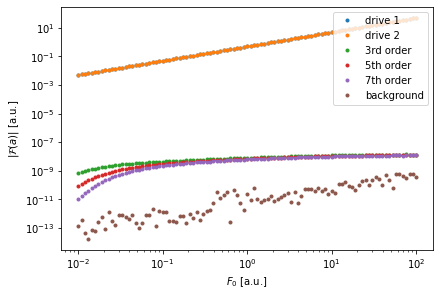

In [24]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig6, ax6 = plt.subplots(1)
plot_paramdependence(F0_arr, A_F0, ax6)
ax6.set_xlabel('$F_0$ [a.u.]')
ax6.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax6.legend()

## Harmonic balance reconstruction

We now want to reconstruct the simulated system using harmonic balance. 
We first expand the square root of the TLS non-linear damping term as

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}} = \kappa_{TLS} \left( 1 - \dfrac{1}{2} \left( \dfrac{|a|}{a_c} \right)^2 + \dfrac{3}{8} \left( \dfrac{|a|}{a_c} \right)^4 + \mathcal{O}(a^6) \right)  $$

Thus, the equation of motion up to $4^{th}$ order is given by

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - (\kappa_0+\kappa_{TLS}) \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\kappa_{TLS}}{2 \lambda^2 a_c^2} \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{3 \kappa_{TLS}}{8 \lambda^4 a_c^4} \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^4 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

For simplicity, we express the previous equation as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - \dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_1 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_3 \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dots - \kappa_n \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}a_{in}. $$

We translate this expression into the Fourier domain, leading to

$$ i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - \dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) + i \omega_r \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_1 \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_3 \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k + \dots + \kappa_n \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k = \dfrac{\lambda^2}{\sqrt{\mathcal{A}}}A_{in,k}. $$

In matrix form we have

$$ \underbrace{\begin{pmatrix} i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - \dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) & i \left( \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) & \dfrac{A_{out,k}}{\sqrt{G}} - \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} & \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k & \dots & \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k \end{pmatrix}}_{\bar{\bar{H}}}  \underbrace{\begin{pmatrix} 1/\lambda^2 \\ \omega_r/\lambda^2 \\ \kappa_1/\lambda^2 \\ \kappa_3/\lambda^2 \\ \vdots \\\kappa_n/\lambda^2 \end{pmatrix}}_{\bar{p}} = \underbrace{\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}}}_{\bar{q}}. $$

In this way we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

To check how many terms we need in the reconstruction, we simulate the damping term (blue line) given by

$$ \kappa_0 + \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}}. $$

We then fit a polynomial (red line)

$$ \kappa_1 + \kappa_3 a^2 + \kappa_5 a^4 + \mathcal{O}(a^6). $$

Depending on the range of |a| we will need more or less polynmial coefficients to properly fit the TLS damping.

PARAMETERS
κ0 = 0.05000
κtls = 0.02500
ac = 1.0
F0 = 1
----------------------------------
FIT PARAMETERS
κ1 = 0.0749986152447032
κ3 = -0.012417796838241818
κ5 = 0.008571379929894636
κ7 = -0.004840207208522957
κ9 = 0.0013695148966639252


Text(0, 0.5, '')

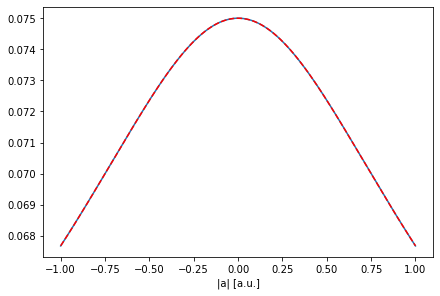

In [87]:
# Parameters
κ0 = 0.05
κtls = 0.025
ac = 1
F0 = 1
gain = 10 ** (20 / 10)
att = 10 ** (20 / 10)

print('PARAMETERS')
print(f'κ0 = {κ0:.5f}')
print(f'κtls = {κtls:.5f}')
print(f'ac = {ac:.1f}')
print(f'F0 = {F0:.0f}')
print('----------------------------------')

# We simulate the TLS non-linearity
x_sim = np.linspace(-1, 1, 1000)
y_sim = κ0 + κtls/np.sqrt(1 + (x_sim/ac)**2)

# Polynomial fit up to nth order
n = np.arange(0, 9, 2)
coefficients = np.polynomial.polynomial.polyfit(x_sim, y_sim, n)

# Fit data
y_fit = 0
print('FIT PARAMETERS')
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val*x_sim**coef_ind
    if coef_ind%2 == 0:
        print(f'κ{coef_ind+1} = {coef_val}')

# Plot
fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, y_sim)
ax7.plot(x_sim, y_fit, 'r--')
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel('')

In [82]:
# Simulation
A, Ain, a_all, a, ain, f, t_arr, drive, imp_ind = nonlinear_simulation(f0, κ0, κtls, ac, λ, f1, f2, F0)

We then simulate again the dynamics of the system with the previous parameters, obtaining:

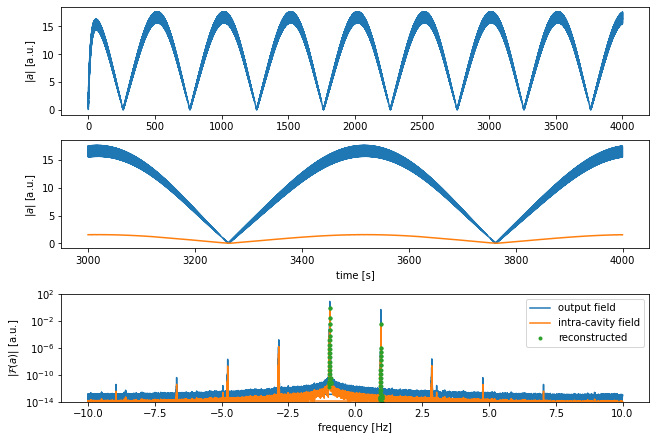

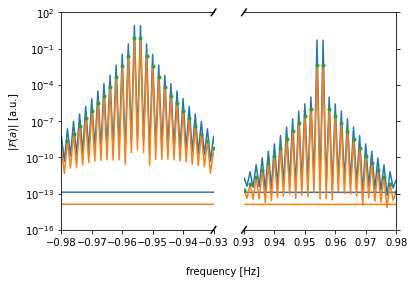

In [83]:
ylim = np.array([1e-14, 100])
fig2 = plot_spectra(t_all, a_all, t_arr, a, ain, f, A, Ain, ylim, imp_ind)

# Plot only the region of interest   
xlim_n = np.array([-0.98, -0.93])
xlim_p = np.array([0.93, 0.98])
ylim = np.array([1e-16, 1e2])
plot_brokenaxis(f, A, A/np.sqrt(gain)-Ain/np.sqrt(att), xlim_n, xlim_p, ylim)

We eventually perform a polynomial recontruction obtaining

f0_recon = 0.95500 Hz
λ_recon = 1.00000
κ1_recon = 0.07496009021325978
κ2_recon = -0.011958198768389407
κ4_recon = 0.007118841573988908
κ6_recon = -0.0031867042923966788
κ8_recon = 0.0008361829756790568
κ10_recon = -9.288166485366722e-05
----------------------------------


Text(0, 0.5, '')

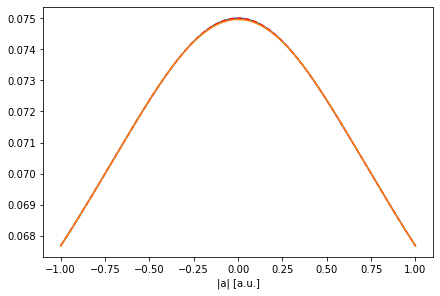

In [92]:
# Reconstruction section
recon_order = np.arange(2, 11, 2)
λ_recon, f0_recon, κ_recon, Qmat_fit = recon_nonlinear(A, Ain, a, ain, f, imp_ind, recon_order)
λ_recon = np.sqrt(λ_recon)

print(f'f0_recon = {f0_recon:.5f} Hz')
print(f'λ_recon = {λ_recon:.5f}')
print(f'κ1_recon = {κ_recon[0]}')
for order_ind, order_val in enumerate(recon_order):
    print(f'κ{order_val}_recon = {κ_recon[order_ind+1]}')
print('----------------------------------')
x_sim = np.linspace(-1, 1, 1000)
y_sim = κ0 + κtls/np.sqrt(1 + (x_sim/ac)**2)
y_recon = 0
y_fit = 0
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val*x_sim**coef_ind
for coef_ind, coef_val in enumerate(κ_recon):
    y_recon += coef_val*x_sim**(2*coef_ind)

# Plotting
fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, y_sim)
ax7.plot(x_sim, y_fit, 'r--')
ax7.plot(x_sim, y_recon)
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel('')

# Phase dependence

We have ignored the elephant in the room, which are phases. 
What role do the phase delays in the lines play in the simulation and reconstruction?

The input-output relations taking phases into account are now:

$$ \dfrac{a_{out}}{e^{i\alpha}\sqrt{G}} = \dfrac{a_{in}}{e^{i\beta}\sqrt{\mathcal{A}}} + \lambda a \quad \rightarrow \quad a = \dfrac{1}{\lambda} e^{i\alpha} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) $$

Plugging this expression in the equation of motion we obtain:

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i\omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_0 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{\kappa_{TLS}}{\sqrt{1 + \left( \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right| / |\lambda|a_c \right)^2 }} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \lambda^2 e^{i(\alpha-\beta)} \dfrac{a_{in}}{\sqrt{\mathcal{A}}} $$